In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import os
import pickle
import random
import seaborn as sns
from tqdm import tqdm
from tqdm import tnrange
from time import time

from sklearn.covariance import MinCovDet
from scipy.stats import chi2


from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, linear_model
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2
from sklearn.preprocessing import minmax_scale, OneHotEncoder
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Input, Dense, Reshape, Concatenate, Flatten, Lambda, Reshape, Dropout
from keras.losses import MeanSquaredError as mse
from tensorflow.keras import backend as K
from keras.optimizers import Adam

In [2]:
DATASETS_PATH = "../Datasets/curated/adl/"
os.listdir(DATASETS_PATH)

['gps_data_2023-05-17_20-22-53.csv', 'mpu6050_data_2023-05-17_20-22-53.csv']

In [3]:
# adl_files = [file_name for file_name in os.listdir() if ".csv" in file_name and "trial" in file_name]
# fall_files = [file_name for file_name in os.listdir() if ".csv" in file_name and "fall" in file_name]

# print(adl_files)
# print(fall_files)

In [4]:
# trial_data_1 = pd.read_csv(DATASETS_PATH+'trial_data_1.csv').iloc[:,1:]
# trial_data_2 = pd.read_csv(DATASETS_PATH+'trial_data_2.csv').iloc[:,1:]
# trial_data_3 = pd.read_csv(DATASETS_PATH+'trial_data_3.csv').iloc[:,1:]
# trial_data_4 = pd.read_csv(DATASETS_PATH+'trial_data_4.csv').iloc[:,1:]
# trial_data_5 = pd.read_csv(DATASETS_PATH+'trial_data_5.csv').iloc[:,1:]

# fall_simulation_2 = pd.read_csv(DATASETS_PATH+'fall_simulation_2.csv').iloc[:,1:]
# fall_simulation_3 = pd.read_csv(DATASETS_PATH+'fall_simulation_3.csv').iloc[:,1:]

In [5]:
# # Only take in accelerometer and gyroscope data
# trial_data_1 = trial_data_1[['Ax','Ay','Az','gx','gy','gz']]
# trial_data_2 = trial_data_2[['Ax','Ay','Az','gx','gy','gz']]
# trial_data_3 = trial_data_3[['Ax','Ay','Az','gx','gy','gz']]
# trial_data_4 = trial_data_4[['Ax','Ay','Az','gx','gy','gz']]
# trial_data_5 = trial_data_5[['Ax','Ay','Az','gx','gy','gz']]

# fall_simulation_2 = fall_simulation_2[['Ax','Ay','Az','gx','gy','gz']]
# fall_simulation_3 = fall_simulation_3[['Ax','Ay','Az','gx','gy','gz']]

In [6]:
filename = "mpu6050_data_2023-05-17_20-22-53.csv"
adl_data = pd.read_csv(DATASETS_PATH+filename).iloc[:,1:]
adl_data = adl_data[['Ax','Ay','Az','gx','gy','gz']]

In [7]:
# Pivoting datasets to have 20 sets of data per row

In [8]:
def pivot_df(df, num_new_cols = 20):
    df = df.copy()
    for num_new_rows in range(1, num_new_cols + 1):
        new_rows = pd.DataFrame([[0,0,0,0,0,0] for i in range(num_new_rows)], columns = ['Ax','Ay','Az','gx','gy','gz'])
        temp_df = pd.concat([
            new_rows, df[['Ax','Ay','Az','gx','gy','gz']]
        ], axis=0).\
        reset_index(drop=True).\
        rename(columns={
            'Ax' : f'Ax{num_new_rows}',
            'Ay' : f'Ay{num_new_rows}',
            'Az' : f'Az{num_new_rows}',
            'gx' : f'gx{num_new_rows}',
            'gy' : f'gy{num_new_rows}',
            'gz' : f'gz{num_new_rows}'
        })
        df = pd.concat([df, temp_df], axis = 1)
    df = df.dropna().iloc[20:,:].reset_index(drop=True)
    return df

In [9]:
# trial_data_1 = pivot_df(trial_data_1)
# trial_data_2 = pivot_df(trial_data_2)
# trial_data_3 = pivot_df(trial_data_3)
# trial_data_4 = pivot_df(trial_data_4)
# trial_data_5 = pivot_df(trial_data_5)

# fall_simulation_2 = pivot_df(fall_simulation_2)
# fall_simulation_3 = pivot_df(fall_simulation_3)

In [10]:
adl_data = pivot_df(adl_data)

In [12]:
# train_data = pd.concat([trial_data_1, trial_data_2, trial_data_3, trial_data_4, trial_data_5]).reset_index(drop=True)
# test_data = pd.concat([fall_simulation_2, fall_simulation_3]).reset_index(drop=True)

In [13]:
train_data = adl_data.copy()

In [14]:
train_data

,Ax,Ay,Az,gx,gy,gz,Ax1,Ay1,Az1,gx1,...,Az19,gx19,gy19,gz19,Ax20,Ay20,Az20,gx20,gy20,gz20
0,10.26,0.46,-2.30,0.14,-0.11,-0.02,10.47,0.82,-1.92,-0.00,...,-2.28,0.13,-0.10,-0.02,10.26,0.46,-2.30,0.14,-0.11,-0.02
1,10.28,0.49,-2.28,0.13,-0.10,-0.02,10.26,0.46,-2.30,0.14,...,-2.29,0.12,-0.08,-0.02,10.28,0.49,-2.28,0.13,-0.10,-0.02
2,10.30,0.50,-2.29,0.12,-0.08,-0.02,10.28,0.49,-2.28,0.13,...,-2.23,0.11,-0.06,-0.02,10.30,0.50,-2.29,0.12,-0.08,-0.02
3,10.29,0.47,-2.23,0.11,-0.06,-0.02,10.30,0.50,-2.29,0.12,...,-2.26,0.10,-0.05,-0.03,10.29,0.47,-2.23,0.11,-0.06,-0.02
4,10.31,0.55,-2.26,0.10,-0.05,-0.03,10.29,0.47,-2.23,0.11,...,-2.33,0.09,-0.03,-0.03,10.31,0.55,-2.26,0.10,-0.05,-0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184875,11.39,3.80,-2.10,0.14,-0.40,-0.92,11.24,3.45,-1.73,0.41,...,-2.58,0.62,0.12,-0.21,10.50,0.17,-2.54,0.59,0.12,-0.20
184876,11.42,3.91,-2.09,-0.13,-0.34,-0.91,11.39,3.80,-2.10,0.14,...,-2.57,0.64,0.13,-0.21,10.45,0.14,-2.58,0.62,0.12,-0.21
184877,11.48,4.02,-2.29,-0.38,-0.27,-0.88,11.42,3.91,-2.09,-0.13,...,-2.56,0.67,0.13,-0.22,10.46,0.19,-2.57,0.64,0.13,-0.21
184878,11.44,4.01,-2.38,-0.64,-0.20,-0.85,11.48,4.02,-2.29,-0.38,...,-2.61,0.70,0.14,-0.22,10.49,0.15,-2.56,0.67,0.13,-0.22


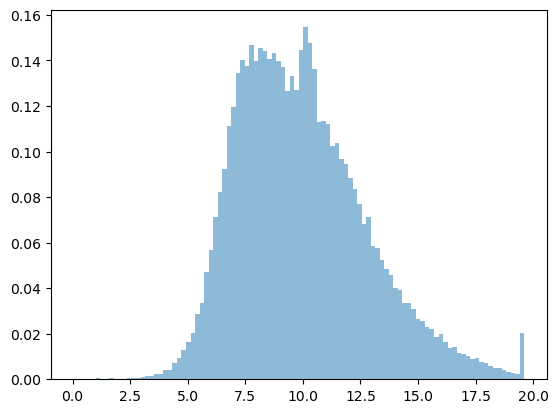

In [16]:
# EDA
plt.hist(np.abs(train_data.Ax), bins=100, alpha=0.5, density=True)
# plt.hist(np.abs(test_data.Ay), bins=100, alpha=0.5, density=True)
plt.show()

In [17]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(train_data)

MinMaxScaler()

In [18]:
train_data_norm_presplit = scaler.transform(train_data)
# test_data_norm = scaler.transform(test_data)

In [19]:
valid_ratio = 0.2
valid_indices = sorted(random.sample(list(range(train_data_norm_presplit.shape[0])), round(train_data_norm_presplit.shape[0] * valid_ratio)))

In [20]:
valid_data = train_data.iloc[valid_indices, :].reset_index(drop = True)
valid_data_norm = train_data_norm_presplit[valid_indices]
train_data_norm = np.delete(train_data_norm_presplit, valid_indices, axis = 0)

In [21]:
train_data_norm.shape

(147904, 126)

## Mahalanobis Distance Outlier Removal

In [22]:
train_data_norm[:,:6].shape

(147904, 6)

In [23]:
# Covariance matrix
# covariance = np.cov(train_data, rowvar=False)

start_time = time()
cov = MinCovDet().fit(train_data_norm[:,:6])
end_time = time()
print(f"Time elapsed: {(end_time - start_time)/60} minutes")
covariance = cov.covariance_


# Covariance matrix power of -1
covariance_pm1 = np.linalg.matrix_power(covariance, -1)

# Center point
centerpoint = np.mean(train_data_norm[:,:6], axis=0)

Time elapsed: 1.1485998948415121 minutes


In [24]:
# Distances between center point and 
distances = []
for i, val in enumerate(train_data_norm[:,:6]):
    p1 = val
    p2 = centerpoint
    distance = (p1-p2).T.dot(covariance_pm1).dot(p1-p2)
    distances.append(distance)
distances = np.array(distances)

# Cutoff (threshold) value from Chi-Sqaure Distribution for detecting outliers 
cutoff_threshold = 0.99
cutoff = chi2.ppf(cutoff_threshold, train_data_norm[:,:6].shape[1])

# Index of outliers
outlierIndexes = np.where(distances > cutoff)

print('--- Index of Outliers ----')
print(outlierIndexes)
print(f"There are {len(outlierIndexes[0])} outliers identified")

# print('--- Observations found as outlier -----')
# print(train_data_norm[distances > cutoff, :])

--- Index of Outliers ----
(array([   584,   1486,   1487, ..., 147465, 147466, 147525], dtype=int64),)
There are 10895 outliers identified


In [25]:
train_data_norm = np.delete(train_data_norm, outlierIndexes, axis = 0)

## Building Model

In [27]:
latent_space_dim = 8
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(latent_space_dim,), mean=0., stddev=1.) # stddev is set to 0.1 in this post: https://blog.keras.io/building-autoencoders-in-keras.html
    return_value = z_mean + K.exp(z_log_sigma) * epsilon
    #print(z_mean)
    
    return return_value

### Encoder

In [28]:
inputs = Input((126,))
layer1 = Dense(126, activation = 'relu')(inputs)
layer2 = Dense(200, activation = 'relu')(layer1) # Changed from 3
layer3 = Dense(100, activation = 'relu')(layer2) # Changed from 3
layer4 = Dense(60, activation = 'relu')(layer3)
layer5 = Dense(30, activation = 'relu')(layer4)
z_mean = Dense(latent_space_dim)(layer5)
z_log_sigma = Dense(latent_space_dim)(layer5)
encoder = keras.Model(inputs, [z_mean, z_log_sigma], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 126)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 126)          16002       ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 200)          25400       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 100)          20100       ['dense_1[0][0]']                
                                                                                            

### Sampler

In [29]:
sampler_input1 = keras.Input(shape=(latent_space_dim,))
sampler_input2 = keras.Input(shape=(latent_space_dim,))
latent_sample = Lambda(sampling, output_shape = (latent_space_dim,))([sampler_input1, sampler_input2])
sampler = keras.Model([sampler_input1, sampler_input2], latent_sample)

### Decoder

In [30]:
latent_inputs = keras.Input(shape=(latent_space_dim,))
layer6 = Dense(20, activation = 'relu')(latent_inputs)
layer7 = Dense(30, activation = 'relu')(layer6)
layer8 = Dense(50, activation = 'relu')(layer7)
layer9 = Dense(100, activation = 'relu')(layer8)
layer10 = Dense(200, activation = 'relu')(layer9)
decoder_outputs = Dense(126, activation = 'sigmoid')(layer10)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense_7 (Dense)             (None, 20)                180       
                                                                 
 dense_8 (Dense)             (None, 30)                630       
                                                                 
 dense_9 (Dense)             (None, 50)                1550      
                                                                 
 dense_10 (Dense)            (None, 100)               5100      
                                                                 
 dense_11 (Dense)            (None, 200)               20200     
                                                                 
 dense_12 (Dense)            (None, 126)               2532

## VAE

In [31]:
class VAE(Model):
    def __init__(self, encoder, sampler, decoder, beta = 1, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.sampler = sampler
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_sigma = self.encoder(data)
            z_log_var = 2 * z_log_sigma
            z = self.sampler([z_mean, z_log_var])
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(data, reconstruction))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss)
            total_loss = reconstruction_loss + self.beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    def test_step(self, data):
        if isinstance(data, tuple):
            #print(f"Ran. data: {data}")
            data = data[0]

        z_mean, z_log_sigma = self.encoder(data)
        z_log_var = 2 * z_log_sigma
        z = self.sampler([z_mean, z_log_var])
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(data, reconstruction))
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(kl_loss)
        total_loss = reconstruction_loss + self.beta * kl_loss
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    
    
    def call(self, data):
        z_mean, z_log_sigma = self.encoder(data)
        z_log_var = 2 * z_log_sigma
        z = self.sampler([z_mean, z_log_var])
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(data, reconstruction))
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(kl_loss)
        total_loss = reconstruction_loss + self.beta * kl_loss
        self.add_metric(kl_loss, name='kl_loss', aggregation='mean')
        self.add_metric(total_loss, name='total_loss', aggregation='mean')
        self.add_metric(reconstruction_loss, name='reconstruction_loss', aggregation='mean')
        return reconstruction
    

In [32]:
vae = VAE(encoder, sampler, decoder, beta = 0.01)
vae.compile(optimizer = 'adam')

In [33]:
callback = EarlyStopping(
    monitor="val_loss",
    patience=5
)

history = vae.fit(x = train_data_norm, y = train_data_norm, # Changed from train_data_norm 
                  epochs = 1000,
                  shuffle = True,
                  batch_size = 32,
                  workers = 8,
                  validation_data = (valid_data_norm, valid_data_norm), # Changed from valid_data_norm
                  callbacks = [callback])

Epoch 1/1000
4282/4282 [==============================] - 22s 4ms/step - loss: 0.6593 - reconstruction_loss: 0.6493 - kl_loss: 0.2205 - val_loss: 0.6735 - val_reconstruction_loss: 0.6715 - val_kl_loss: 0.2031
Epoch 2/1000
4282/4282 [==============================] - 14s 3ms/step - loss: 0.6358 - reconstruction_loss: 0.6322 - kl_loss: 0.2968 - val_loss: 0.6731 - val_reconstruction_loss: 0.6708 - val_kl_loss: 0.2298
Epoch 3/1000
4282/4282 [==============================] - 13s 3ms/step - loss: 0.6343 - reconstruction_loss: 0.6311 - kl_loss: 0.3006 - val_loss: 0.6743 - val_reconstruction_loss: 0.6722 - val_kl_loss: 0.2060
Epoch 4/1000
4282/4282 [==============================] - 14s 3ms/step - loss: 0.6338 - reconstruction_loss: 0.6304 - kl_loss: 0.3137 - val_loss: 0.6757 - val_reconstruction_loss: 0.6735 - val_kl_loss: 0.2202
Epoch 5/1000
4282/4282 [==============================] - 17s 4ms/step - loss: 0.6329 - reconstruction_loss: 0.6297 - kl_loss: 0.3239 - val_loss: 0.6739 - val_recon

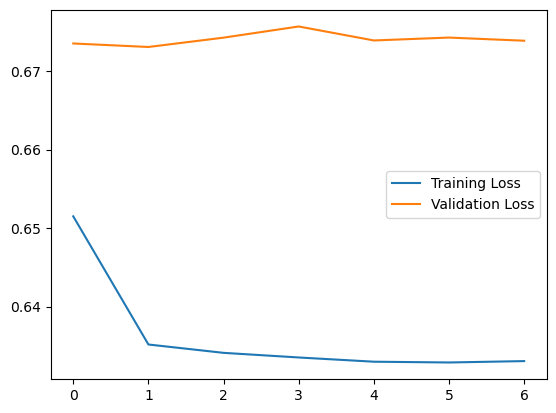

In [34]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.show()

In [35]:
train_predictions = vae.predict(train_data_norm)
# test_predictions = vae.predict(test_data_norm)
valid_predictions = vae.predict(valid_data_norm)

1156/1156 [==============================] - 2s 1ms/step


In [36]:
print(f"Training MAE: {np.sum(np.abs(train_data_norm - train_predictions))/(train_data_norm.shape[0] * train_data_norm.shape[1])}")
# print(f"Testing MAE (Anomalous Data): {np.sum(np.abs(test_data_norm - test_predictions))/(test_data_norm.shape[0] * test_data_norm.shape[1])}")
print(f"Validation MAE (Normal Data): {np.sum(np.abs(valid_data_norm - valid_predictions))/(valid_data_norm.shape[0] * valid_data_norm.shape[1])}")

Training MAE: 0.08138985949353633
Validation MAE (Normal Data): 0.08390125179436578


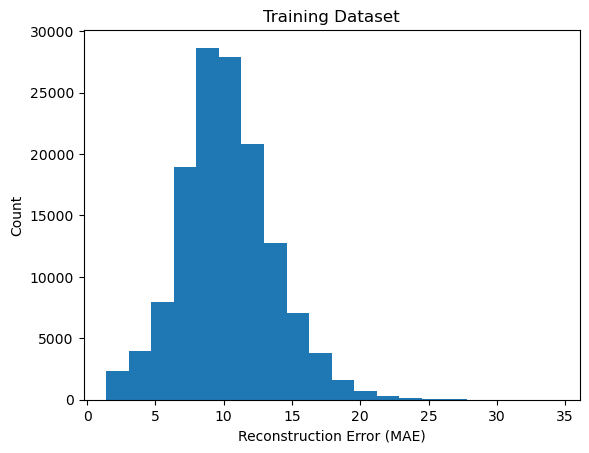

In [37]:
train_mae = np.sum(np.abs(train_data_norm - train_predictions), axis = 1)
plt.hist(train_mae, bins = 20)
plt.title("Training Dataset")
plt.xlabel("Reconstruction Error (MAE)")
plt.ylabel("Count")
plt.show()

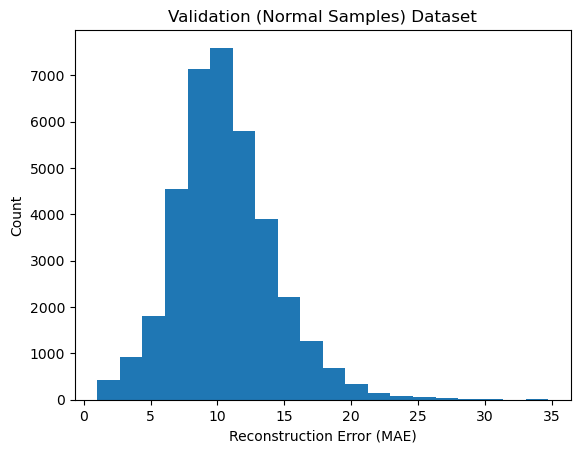

In [38]:
valid_mae = np.sum(np.abs(valid_data_norm - valid_predictions), axis = 1)
plt.hist(valid_mae, bins = 20)
plt.title("Validation (Normal Samples) Dataset")
plt.xlabel("Reconstruction Error (MAE)")
plt.ylabel("Count")
plt.show()

In [39]:
# test_mae = np.sum(np.abs(test_data_norm - test_predictions), axis = 1)
# plt.hist(test_mae, bins = 20)
# plt.title("Testing (Anomalous) Dataset")
# plt.xlabel("Reconstruction Error (MAE)")
# plt.ylabel("Count")
# plt.show()

In [40]:
best_threshold = np.quantile(valid_mae, 0.9)

In [41]:
best_threshold

15.262838031565451

In [42]:
train_data["mae"] = np.sum(np.abs(scaler.transform(train_data) - vae.predict(scaler.transform(train_data))), axis = 1)
train_data["is_anomalous"] = train_data.mae > best_threshold

# test_data["mae"] = test_mae
# test_data["is_anomalous"] = test_mae > best_threshold

5778/5778 [==============================] - 20s 3ms/step


In [43]:
# test_data

In [45]:
# plt.scatter(test_data.index, test_data.mae, s = 0.2)
# plt.axhline(y=best_threshold, color='r', linestyle='-')
# plt.show()

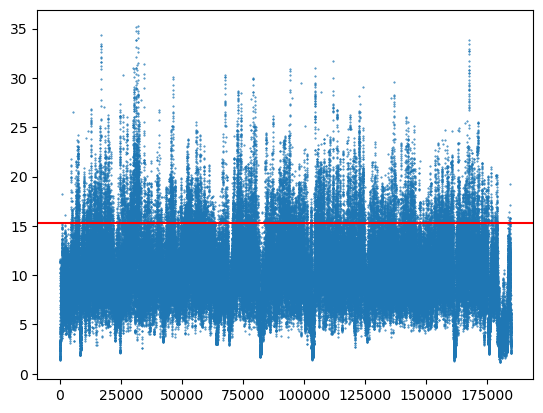

In [46]:
plt.scatter(train_data.index, train_data.mae, s = 0.2)
plt.axhline(y=best_threshold, color='r', linestyle='-')
plt.show()

In [47]:
# np.sum(test_data.is_anomalous)/test_data.shape[0]

In [48]:
np.sum(train_data.is_anomalous)/train_data.shape[0]

0.10069774989182172

## Saving Model

In [49]:
# model_name = "new_vae_windowing_loss_beta_0_01"
# model_path = "../Model/weights/"
# vae.save_weights(model_path + model_name)

In [50]:
# pickle.dump(scaler, open(model_path + 'new_scaler_windowing.pkl', 'wb'))

## Loading Model

In [51]:
latent_space_dim = 8
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(latent_space_dim,), mean=0., stddev=1.) # stddev is set to 0.1 in this post: https://blog.keras.io/building-autoencoders-in-keras.html
    return_value = z_mean + K.exp(z_log_sigma) * epsilon
    #print(z_mean)
    
    return return_value

In [52]:
inputs = Input((126,))
layer1 = Dense(126, activation = 'relu')(inputs)
layer2 = Dense(200, activation = 'relu')(layer1) # Changed from 3
layer3 = Dense(100, activation = 'relu')(layer2) # Changed from 3
layer4 = Dense(60, activation = 'relu')(layer3)
layer5 = Dense(30, activation = 'relu')(layer4)
z_mean = Dense(latent_space_dim)(layer5)
z_log_sigma = Dense(latent_space_dim)(layer5)
encoder = keras.Model(inputs, [z_mean, z_log_sigma], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 126)]        0           []                               
                                                                                                  
 dense_13 (Dense)               (None, 126)          16002       ['input_5[0][0]']                
                                                                                                  
 dense_14 (Dense)               (None, 200)          25400       ['dense_13[0][0]']               
                                                                                                  
 dense_15 (Dense)               (None, 100)          20100       ['dense_14[0][0]']               
                                                                                            

In [53]:
sampler_input1 = keras.Input(shape=(latent_space_dim,))
sampler_input2 = keras.Input(shape=(latent_space_dim,))
latent_sample = Lambda(sampling, output_shape = (latent_space_dim,))([sampler_input1, sampler_input2])
sampler = keras.Model([sampler_input1, sampler_input2], latent_sample)

In [54]:
latent_inputs = keras.Input(shape=(latent_space_dim,))
layer6 = Dense(20, activation = 'relu')(latent_inputs)
layer7 = Dense(30, activation = 'relu')(layer6)
layer8 = Dense(50, activation = 'relu')(layer7)
layer9 = Dense(100, activation = 'relu')(layer8)
layer10 = Dense(200, activation = 'relu')(layer9)
decoder_outputs = Dense(126, activation = 'sigmoid')(layer10)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense_20 (Dense)            (None, 20)                180       
                                                                 
 dense_21 (Dense)            (None, 30)                630       
                                                                 
 dense_22 (Dense)            (None, 50)                1550      
                                                                 
 dense_23 (Dense)            (None, 100)               5100      
                                                                 
 dense_24 (Dense)            (None, 200)               20200     
                                                                 
 dense_25 (Dense)            (None, 126)               2532

In [55]:
class VAE(Model):
    def __init__(self, encoder, sampler, decoder, beta = 1, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.sampler = sampler
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_sigma = self.encoder(data)
            z_log_var = 2 * z_log_sigma
            z = self.sampler([z_mean, z_log_var])
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(data, reconstruction))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss)
            total_loss = reconstruction_loss + self.beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    def test_step(self, data):
        if isinstance(data, tuple):
            #print(f"Ran. data: {data}")
            data = data[0]

        z_mean, z_log_sigma = self.encoder(data)
        z_log_var = 2 * z_log_sigma
        z = self.sampler([z_mean, z_log_var])
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(data, reconstruction))
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(kl_loss)
        total_loss = reconstruction_loss + self.beta * kl_loss
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    
    
    def call(self, data):
        z_mean, z_log_sigma = self.encoder(data)
        z_log_var = 2 * z_log_sigma
        z = self.sampler([z_mean, z_log_var])
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(data, reconstruction))
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(kl_loss)
        total_loss = reconstruction_loss + self.beta * kl_loss
        self.add_metric(kl_loss, name='kl_loss', aggregation='mean')
        self.add_metric(total_loss, name='total_loss', aggregation='mean')
        self.add_metric(reconstruction_loss, name='reconstruction_loss', aggregation='mean')
        return reconstruction
    

In [56]:
vae = VAE(encoder, sampler, decoder, beta = 0.01)
vae.compile(optimizer = 'adam')

In [57]:
pwd

'C:\\Users\\ernest.liu\\Documents\\git\\Morphine-22-23\\ML\\Model Experiment'

In [58]:
model_path = "../Model/weights/"
model_name = "new_vae_windowing_loss_beta_0_01"
vae.load_weights(model_path + model_name)

In [59]:
train_predictions = vae.predict(train_data_norm)
# test_predictions = vae.predict(test_data_norm)
valid_predictions = vae.predict(valid_data_norm)

1156/1156 [==============================] - 4s 3ms/step


In [60]:
valid_mae = np.sum(np.abs(valid_data_norm - valid_predictions), axis = 1)
best_threshold = np.quantile(valid_mae, 0.9)

In [61]:
best_threshold

15.292580977714717